In [52]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from fastai.vision.all import *

from torch.utils.data import Dataset
from torchvision.utils import make_grid
from PIL import Image

In [2]:
%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

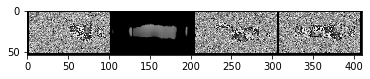

In [3]:


#Probablemente no haga falta normalizar porque ya estan normalizadas
class DatasetPersonalizado(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        self.total_imgs = os.listdir(main_dir)

    def __len__(self):
        return len(self.total_imgs)
    
    def __getitem__(self, index):
        img_loc = os.path.join(self.main_dir, self.total_imgs[index])
        image = Image.open(img_loc)
        image = self.transform(image)
        if self.total_imgs[index][0].isupper():
            label = 1
        else: label = 0
        #label = self.total_imgs[index].isupper()
        return (image, label)

transform = transforms.ToTensor()

dataset = DatasetPersonalizado('./DatasetSoldadurasJuntas/' , transform)
#Numero de imagenes con las que vamos a entrenar


train_set, test_set = torch.utils.data.random_split(dataset, [1300, 202],
        generator=torch.Generator().manual_seed(42))

trainloader = torch.utils.data.DataLoader(train_set, batch_size=5, shuffle=True, num_workers=2)   

testloader = torch.utils.data.DataLoader(test_set, batch_size=5, shuffle=True, num_workers=2)  


#Ver como seleccionar las imagenes que vamos a mostrar adecuadamente
img_list = []

for i in range(4):
    img_list.append(train_set.__getitem__(i)[0])

#print(img_list)
show(make_grid(img_list))


#img_list[0].size()

In [4]:
#Definimos la red neuronal
import torch.nn as nn
import torch.nn.functional as F

class Red(nn.Module):
    def __init__(self):
        super(Red, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 6)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 16, 6)
        self.fc1 = nn.Linear(16 * 8 * 21 , 120)
        self.fc2 = nn.Linear(120, 10)
        self.fc3 = nn.Linear(10, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
#print(x.size())
        x = x.view(x.size(0), 16 * 8 * 21)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


red = Red()




In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torchvision.transforms as transforms

Estamos dentro
Estamos dentro
x1 :  69 x2 :  82 y1: 19 y2: 45


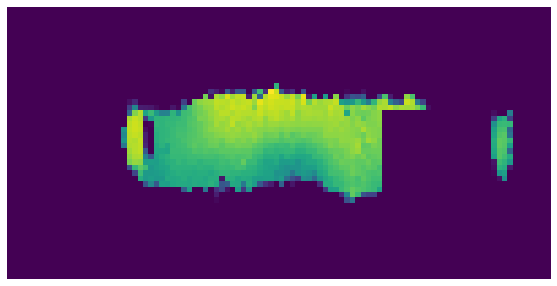

In [57]:
import skimage.util
import numpy as np
import cv2

#from skimage import data , io

#print(scikit.image.__version__)

class AddGaussianNoise:
    """Clase para añadir ruido gausiano"""

    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


class RandomCrop(object):
    """Clase para hacer el recorte en la parte derecha de la imagen"""
    def __init__(self, max_x, max_y,posicion):
        self.max_x = max_x
        self.max_y = max_y
        self.posicion = posicion
    
    def __call__(self,tensor):

        x1 = x2 = 0
        if self.posicion =='derecha':
            print('Estamos dentro')
            x1 = random.randint(30, 50 + self.max_x)
            x2 = random.randint(50 + self.max_x, 100)

        elif self.posicion =='izquierda':
            x1 = random.randint(0, self.max_x)
            x2 = random.randint(self.max_x + 20, 60)
       
        print('Estamos dentro')
        y1 = random.randint(0, self.max_y)
        y2 = random.randint(self.max_y + 10,50)
        tensor[0, y1:y2, x1:x2] = 0
        print('x1 : ' , x1 , 'x2 : ' , x2 , 'y1:' , y1 , 'y2:', y2)

        return tensor



class RuidoScikit(object):
    """Clase para aplicar ruido gausiano mediante sci-kit."""
    def __init__(self,mode,seed):
        self.mode = mode
        self.seed = seed

    def __call__(self, image):
        image = np.asarray(image)
        image = skimage.util.random_noise(image, mode=self.mode , seed=self.seed)
        return image

image = Image.open('./DatasetSoldaduras/NFD1/Pieza_39_Soldadura_77.png')
image2 = Image.open('./DatasetSoldadurasJuntas/Pieza_81_Soldadura_77.png')
image3 = Image.open('./DatasetSoldadurasJuntas/Pieza_81_Soldadura_77.png')

# #image2 = cv2.imread('./DatasetSoldaduras/NFD1/Pieza_39_Soldadura_77.png' , cv2.IMREAD_GRAYSCALE)
# image2 = Image.open('./DatasetSoldaduras/NFD1/Pieza_39_Soldadura_77.png')

# display(image)

#image = np.asarray(image)
image2 = np.asarray(image2)

trans_ruido = RuidoScikit('gaussian',42)
trans_corte = RandomCrop(20,20,'derecha')
trans_tensor = transforms.ToTensor()
trans_pil = transforms.ToPILImage()
trans_resize = transforms.Resize((50,100))
image3 = trans_ruido(image3)

# print(np.count_nonzero(image))

# print(image)

image = trans_tensor(image)
image = trans_resize(image)
image = trans_corte(image)
image = PILImage(trans_pil(image))
image.show(figsize=(10,5))



#image = skimage.util.random_noise(image, mode='gaussian' , seed=42)
image2 = skimage.util.random_noise(image2, mode='gaussian' , seed=42)

# ruido = transforms.Compose([
#     transforms.ToTensor(),
#     #AddGaussianNoise(0.4,0.14),
#     AddGaussianNoise(0,0.01),
#     transforms.ToPILImage()
# ])

# image2 = ruido(image)

# display(image2)

# print(np.count_nonzero(image))

# trans_tensor = transforms.ToTensor()
# trans_image = transforms.ToPILImage()


# image = Image.fromarray((image * 255).astype(np.uint8))

# display(image)

# image = trans_tensor(image)

# img_list = []
# for i in range(4):
#     img_list.append(image)


#image.save('imagenRuido.png')

#image.show()


torch.Size([80, 480])
torch.Size([3, 3])


<AxesSubplot:>

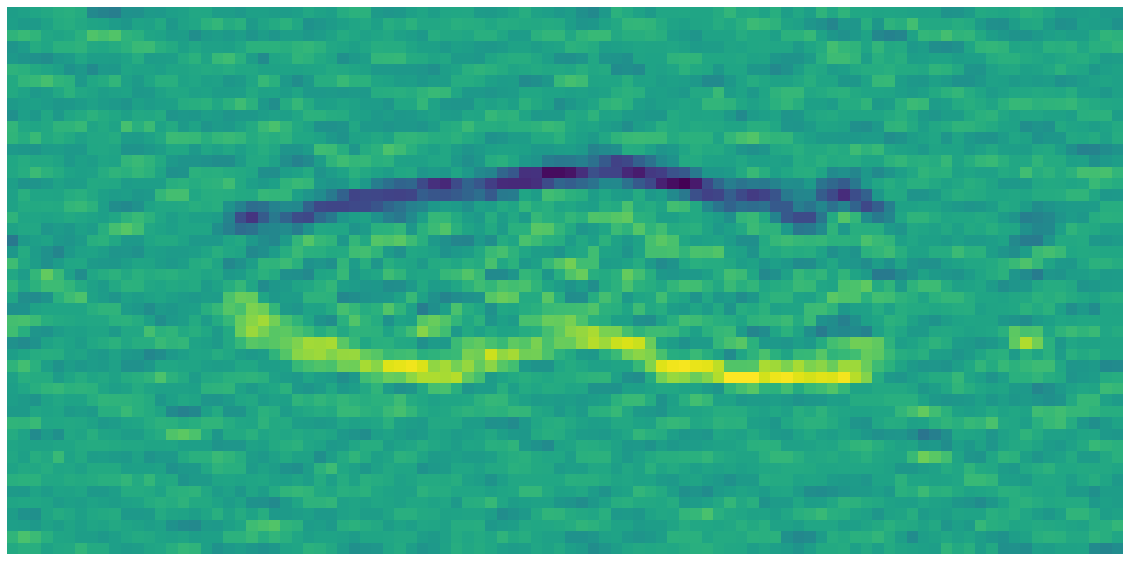

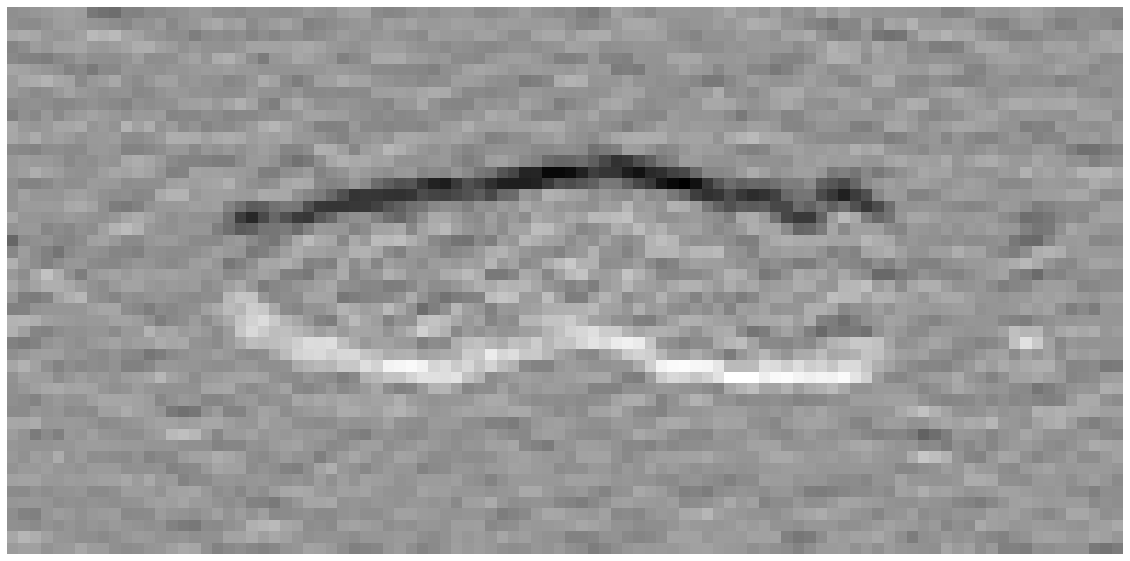

In [8]:
diag1_edge = tensor([[ 0,-1, 1],
                     [-1, 1, 0],
                     [ 1, 0, 0]]).float()

diag2_edge = tensor([[ 1,-1, 0],
                     [ 0, 1,-1],
                     [ 0, 0, 1]]).float()

top_edge = tensor([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]]).float()

left_edge = tensor([[-1, 0, 1],
                    [-1, 0, 1],
                    [-1, 0, 1]]).float()


bottom_edge = tensor([[ 1, 1, 1],
                      [ 0, 0, 0],
                      [-1,-1,-1]]).float()    

imagen_prueba = tensor(image)
imagen_prueba2 = tensor(image2)

imagen_prueba3 = tensor(image3)


def apply_kernel(row, col, kernel):
    return (imagen_prueba2[row-1:row+2,col-1:col+2] * kernel).sum()

print(imagen_prueba.size())
print(bottom_edge.size())
#rng_y = range(1,79)
#rng_x = range(1,479)
rng_y = range(1,49)
rng_x = range(1,99)
bottom_edge_imagen = tensor([[apply_kernel(i,j,bottom_edge) for j in rng_x] for i in rng_y])
top_edge_imagen = tensor([[apply_kernel(i,j,top_edge) for j in rng_x] for i in rng_y])
show_image(bottom_edge_imagen , figsize = [20 , 120] ,)
show_image(top_edge_imagen , figsize = [20 , 120] , cmap = 'binary')


# edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])
# print(edge_kernels.shape)
# #img_list = torch.stack(img_list)
# edge_kernels = edge_kernels.unsqueeze(1)
# print(edge_kernels.size())

# print(img_list.size())

# features = F.conv2d(img_list , edge_kernels)
# print('El tamaño de las features es :',features.shape)
# print(len(features))
# print(features.size())
# # for i in range(len(features)):
# #     (trans_image(features[i])).show()
# #show(make_grid(features[0]))
# #show(make_grid(features[1]))
# #show(make_grid(features[2]))
# show(make_grid(features[3]))



In [8]:
#Definimos una funcion de perdida.
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(red.parameters() , lr=0.001, momentum=0.8)

In [9]:


# Writer will output to ./runs/ directory by default



In [10]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

losses , accuracies = [] , []

for epoch in range(30):  # loop over the dataset multiple times

    running_loss = 0.0
    running_correct = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = red(inputs)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        loss.backward()
        optimizer.step()

        # print statistics
        #loss.item()
        
        running_loss += loss.item()
        running_correct += (predicted == labels).sum().item()


        if i % 200 == 199:    # every 200 mini-batches...

            # ...log the running loss
            writer.add_scalar('training loss',
                            running_loss / 200,
                            epoch * len(trainloader) + i)

            writer.add_scalar('training accuracy',
                            running_correct/ 200,
                            epoch * len(trainloader) + i)
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

"""
        writer.add_scalar('Loss/train', running_loss , global_step=epoch)
        losses.append(loss.item())
"""
#       if i % 200 == 199:    # print every 2000 mini-batches




print('Finished Training')
writer.add_graph(red,inputs)



#plt.plot(losses)


[1,   200] loss: 0.677
[2,   200] loss: 0.676
[3,   200] loss: 0.668
[4,   200] loss: 0.610
[5,   200] loss: 0.486
[6,   200] loss: 0.429
[7,   200] loss: 0.360
[8,   200] loss: 0.151
[9,   200] loss: 0.059
[10,   200] loss: 0.043
[11,   200] loss: 0.025
[12,   200] loss: 0.019
[13,   200] loss: 0.018
[14,   200] loss: 0.009
[15,   200] loss: 0.013
[16,   200] loss: 0.007
[17,   200] loss: 0.007
[18,   200] loss: 0.005
[19,   200] loss: 0.005
[20,   200] loss: 0.010
[21,   200] loss: 0.002
[22,   200] loss: 0.004
[23,   200] loss: 0.003
[24,   200] loss: 0.002
[25,   200] loss: 0.002
[26,   200] loss: 0.002
[27,   200] loss: 0.001
[28,   200] loss: 0.001
[29,   200] loss: 0.001
[30,   200] loss: 0.001
Finished Training


In [11]:
len(losses)
perdida = loss.item()
print(perdida)
print(loss.type())

6.877890700707212e-05
torch.FloatTensor


In [12]:
PATH = './soldaduras.pth'
torch.save(red.state_dict(), PATH)

GroundTruth:  tensor(1) tensor(1) tensor(0) tensor(0) tensor(0)


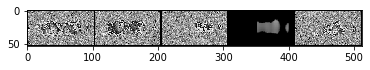

In [13]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
show(torchvision.utils.make_grid(images))

print('GroundTruth: ', ' '.join('%5s' % labels[j] for j in range(5)))

In [14]:
red = Red()
red.load_state_dict(torch.load(PATH))

outputs = red(images)

predicted = []

"""
for i in range(4):
    print(outputs[i])
    predicted.append(torch.)
"""
print(outputs)
predicted = torch.max(outputs,1)
print(predicted)
values = predicted[1]

#print('Predicted: ', ' '.join('%5s' % predicted[1]
#                              for j in range(2)))

print('Predicted: ', ' '.join('%5s' % values[j]
                                 for j in range(5)))

tensor([[-3.9447,  4.0376],
        [-4.5390,  4.5780],
        [ 8.6478, -7.2487],
        [ 5.7191, -4.8423],
        [ 5.6318, -4.5117]], grad_fn=<AddmmBackward>)
torch.return_types.max(
values=tensor([4.0376, 4.5780, 8.6478, 5.7191, 5.6318], grad_fn=<MaxBackward0>),
indices=tensor([1, 1, 0, 0, 0]))
Predicted:  tensor(1) tensor(1) tensor(0) tensor(0) tensor(0)


In [15]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = red(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))
print('Total: %d , Correct: %d'  % (total , correct))

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
grid = torchvision.utils.make_grid(images)
writer.add_image('images' , grid , 0)

print('GroundTruth: ', ' '.join('%5s' % labels[j] for j in range(5)))


writer.close()


    

Accuracy of the network on the 10000 test images: 100 %
Total: 202 , Correct: 202
GroundTruth:  tensor(0) tensor(0) tensor(0) tensor(0) tensor(0)
